# 1. With leakage

## 1.1. Load the dataset

In [1]:
from utils.globalConst import *

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from DatasetLoader.FrameImageDataset import FrameImageDataset
from DatasetLoader.FrameVideoDataset import FrameVideoDataset

train_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(5),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.ToTensor(),
])

val_test_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
])

- - -
## 1.2. Train the models

In [4]:
import torch.optim as optim
import torch.nn as nn

### 1.2.1. Output aggregation

In [5]:
frameimage_train_loader = DataLoader(
    dataset=FrameImageDataset(split='train', transform=train_transform, leakage=True), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
frameimage_val_loader = DataLoader(
    dataset=FrameImageDataset(split='val', transform=val_test_transform, leakage=True), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
frameimage_test_loader = DataLoader(
    dataset=FrameImageDataset(split='test', transform=val_test_transform, leakage=True), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

In [6]:
framevideolist_train_loader = DataLoader(
    dataset=FrameVideoDataset(split='train', transform=train_transform, leakage=True, stack_frames=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
framevideolist_val_loader = DataLoader(
    dataset=FrameVideoDataset(split='val', transform=val_test_transform, leakage=True, stack_frames=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
framevideolist_test_loader = DataLoader(
    dataset=FrameVideoDataset(split='test', transform=val_test_transform, leakage=True, stack_frames=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

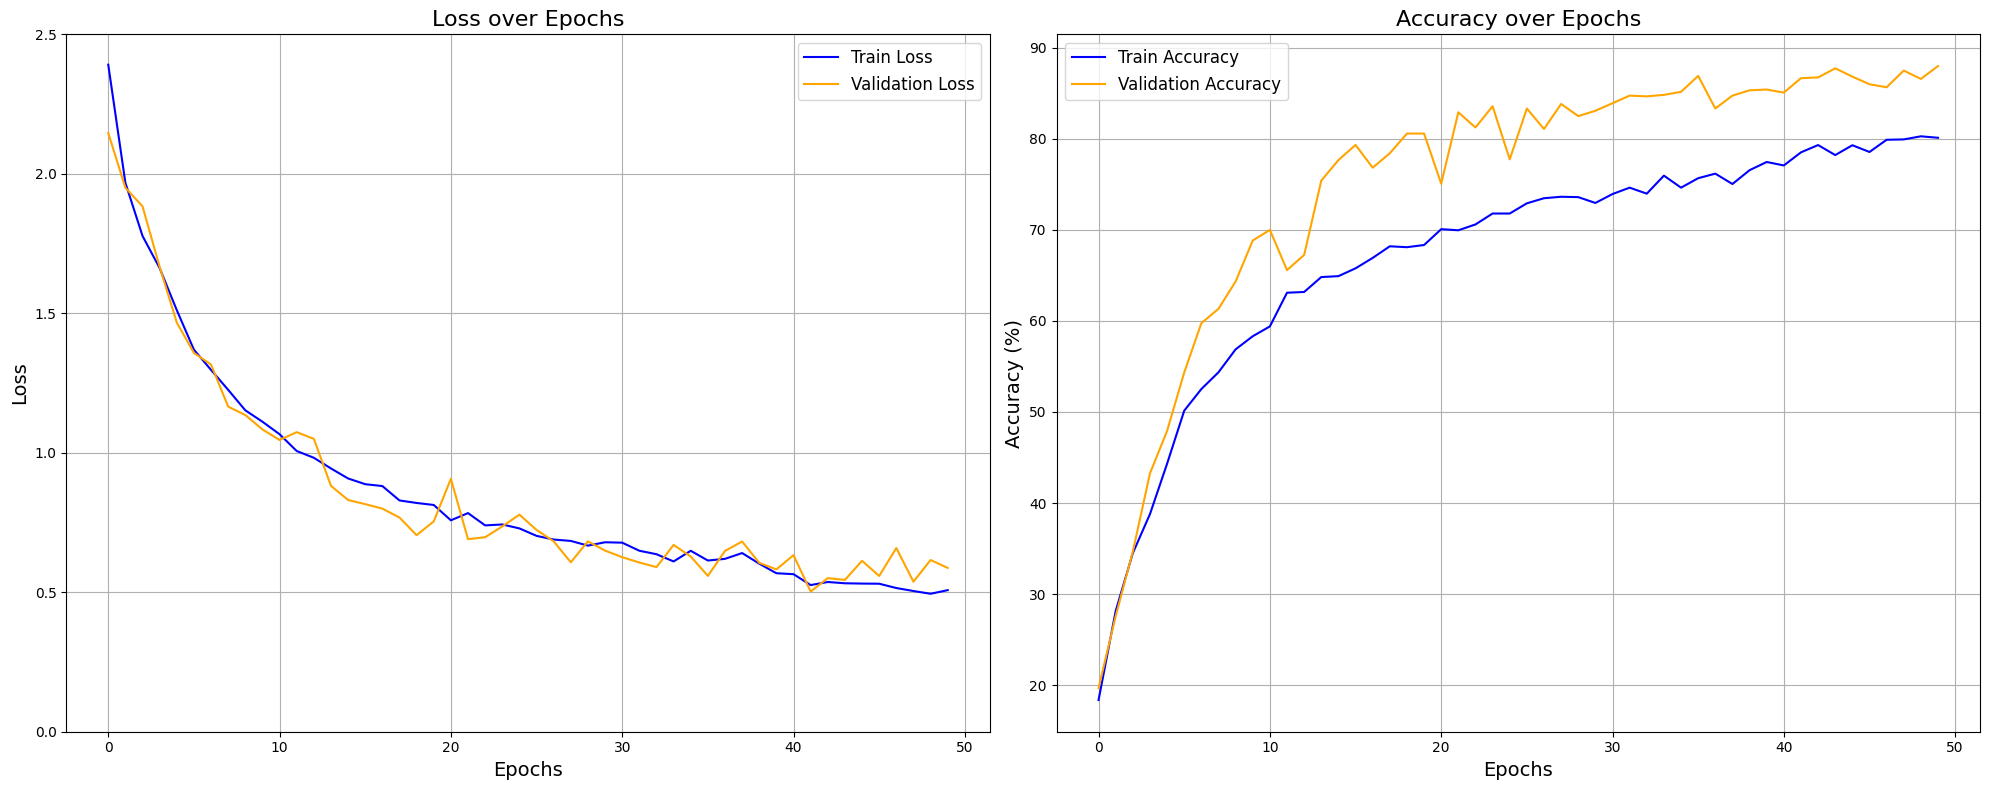

In [ ]:
from Models.OutputAggregation import OutputAggregation

model = OutputAggregation(device).to(device)
model.train_(
    num_epochs=50,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4),
    criterion=nn.CrossEntropyLoss(),
    train_loader=frameimage_train_loader,
    val_loader=frameimage_val_loader,
    plot=True
)

In [8]:
model.eval_(test_loader=framevideolist_test_loader)

Test accuracy: 90.0%


### 1.2.2. Late fusion with MLP

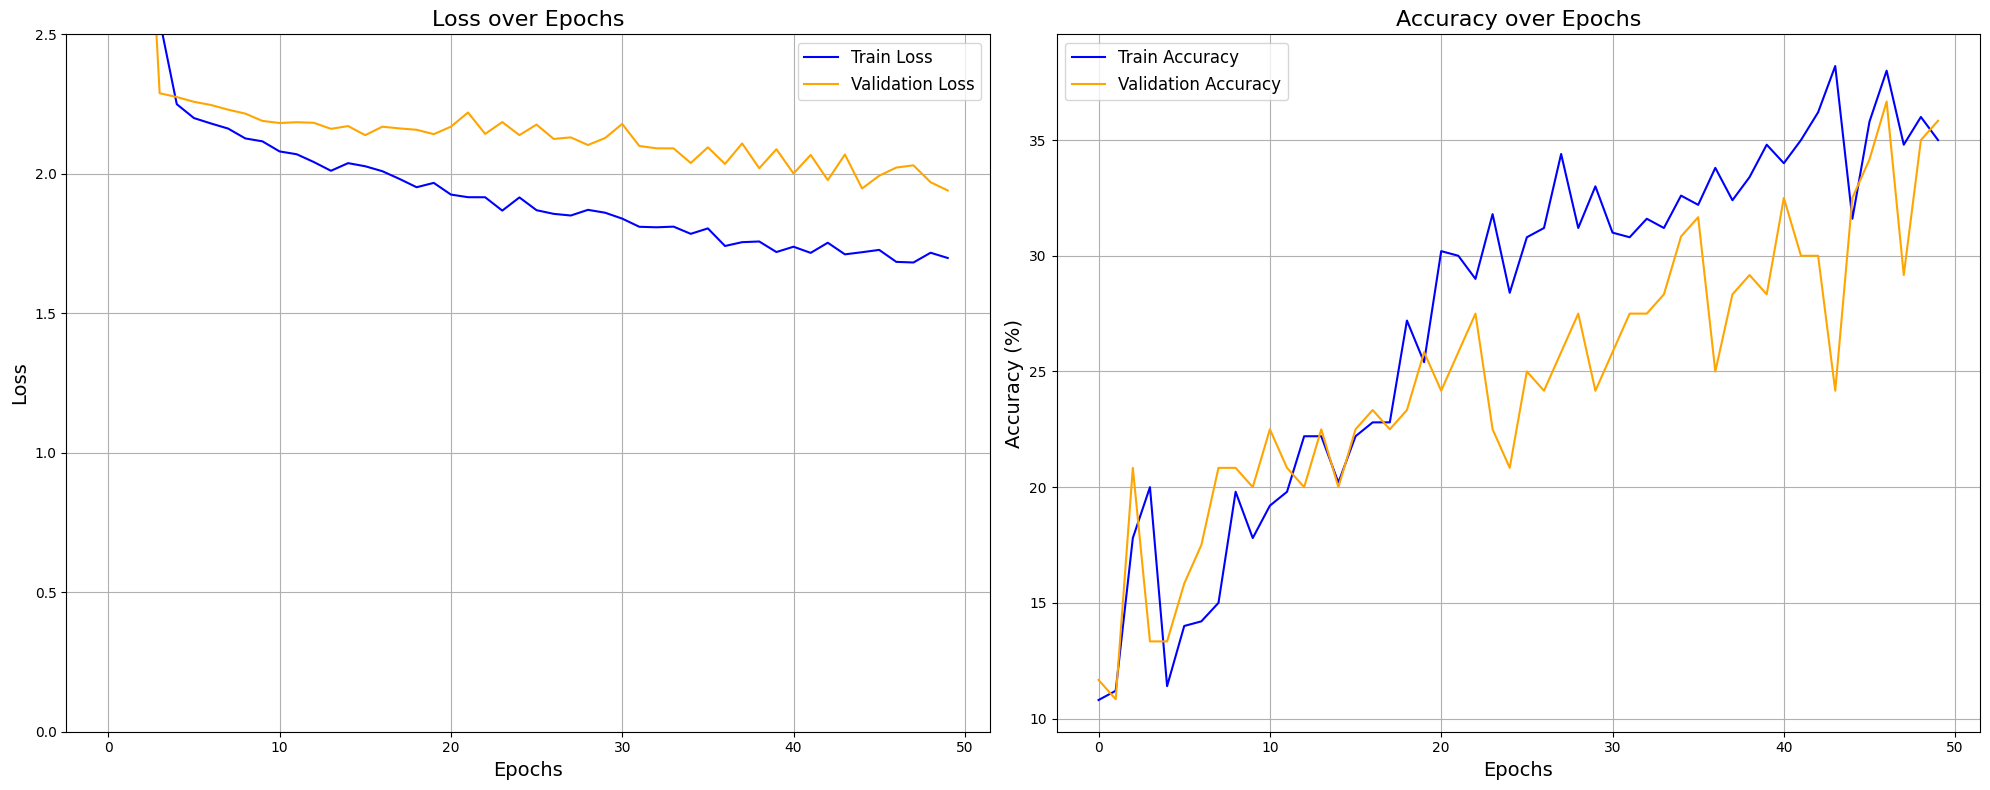

In [10]:
from Models.LateFusionMLP import LateFusionMLP

model = LateFusionMLP(device).to(device)
model.train_(
    num_epochs=50,
    optimizer=optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4),
    criterion=nn.CrossEntropyLoss(),
    train_loader=framevideolist_train_loader,
    val_loader=framevideolist_val_loader,
    plot=True
)

### 1.2.3. Late fusion with Pooling

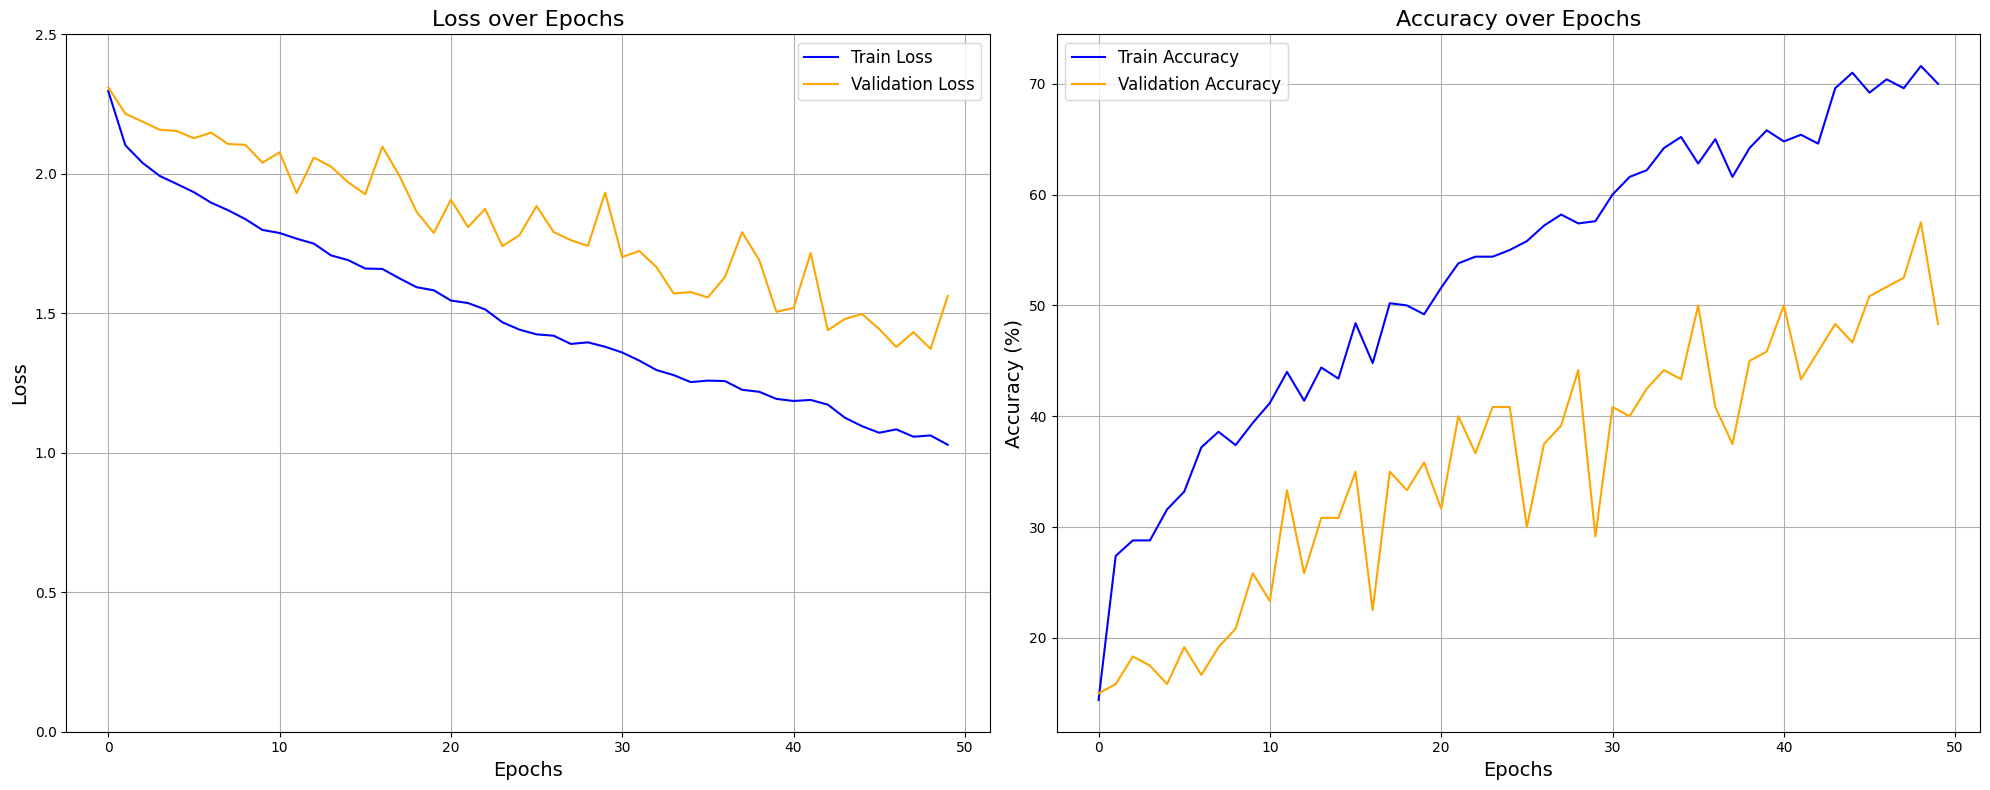

In [11]:
from Models.LateFusionPooling import LateFusionPooling

model = LateFusionPooling(device).to(device)
model.train_(
    num_epochs=50,
    optimizer=optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4),
    criterion=nn.CrossEntropyLoss(),
    train_loader=framevideolist_train_loader,
    val_loader=framevideolist_val_loader,
    plot=True
)

### 1.2.4. Early fusion

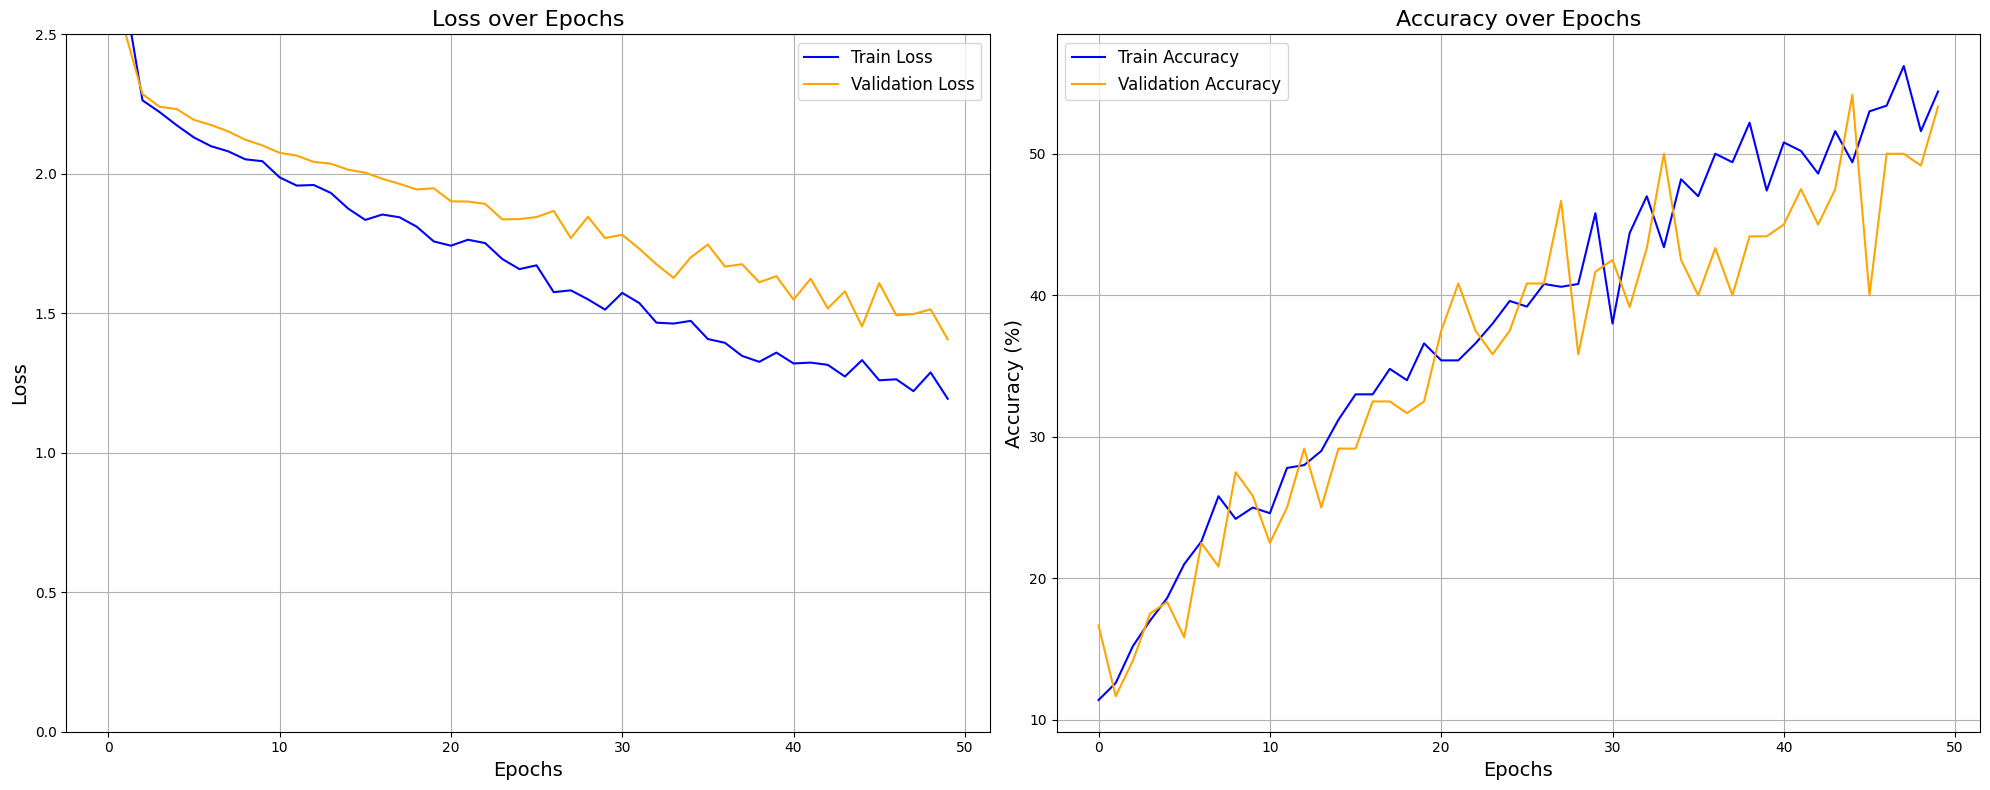

In [12]:
from Models.EarlyFusion import EarlyFusion

model = EarlyFusion(device).to(device)
model.train_(
    num_epochs=50,
    optimizer=optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4),
    criterion=nn.CrossEntropyLoss(),
    train_loader=framevideolist_train_loader,
    val_loader=framevideolist_val_loader,
    plot=True
)

### 1.2.5. 3D CNN

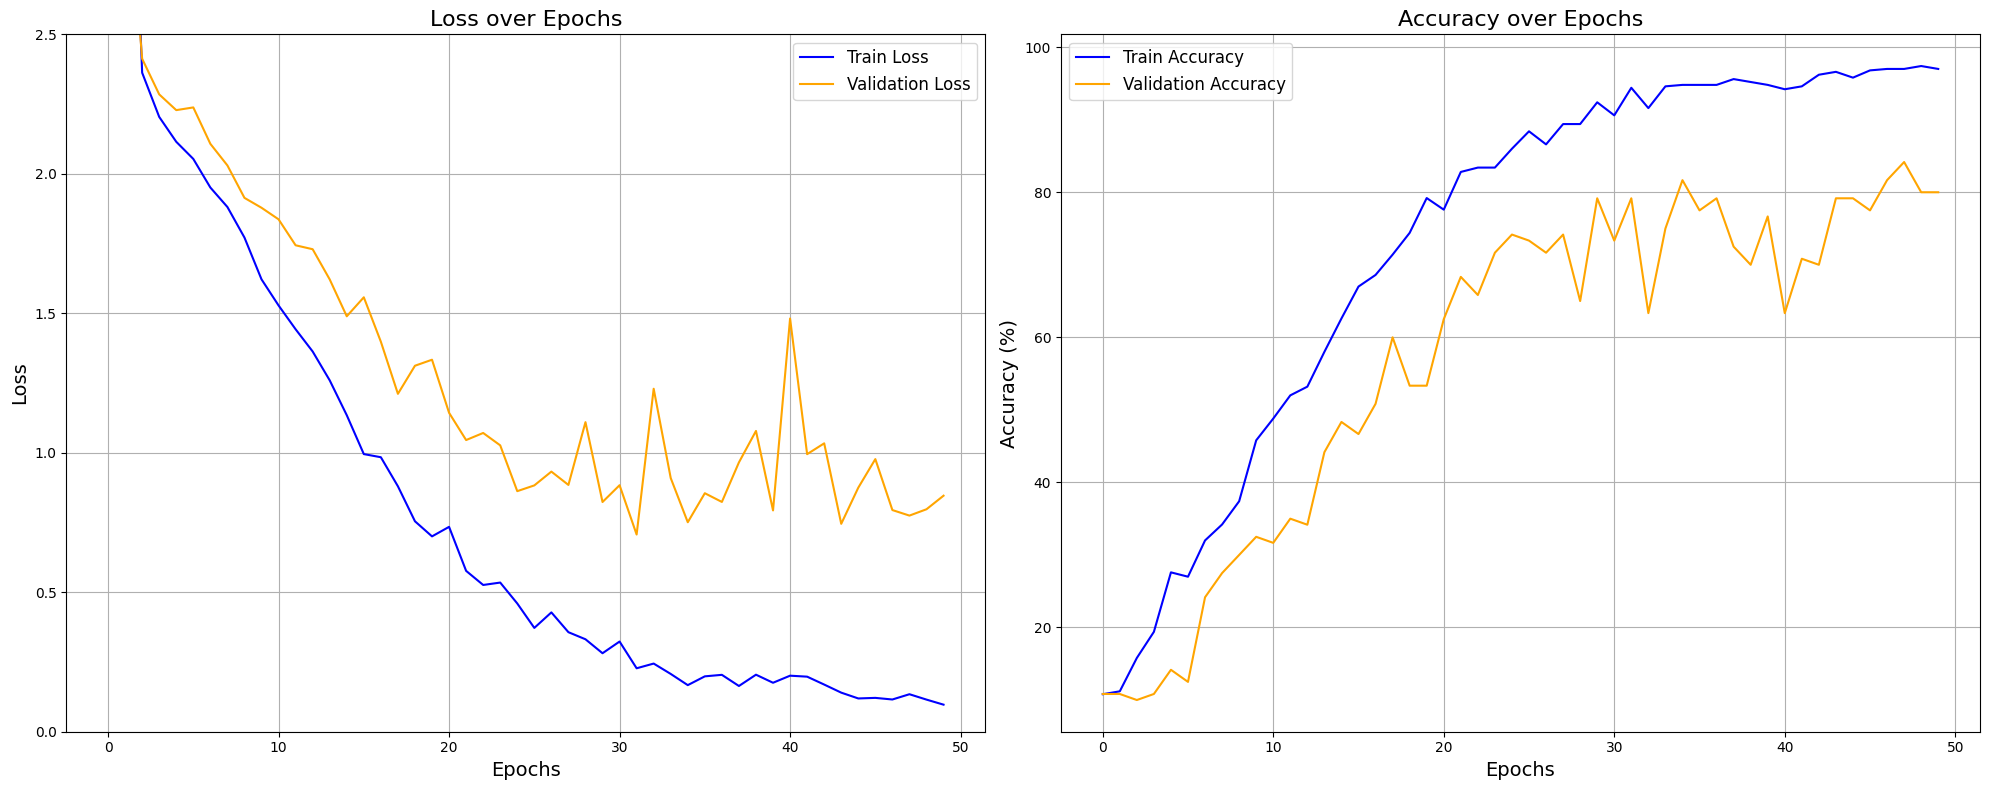

In [13]:
from Models.CNN3D import CNN3D

model = CNN3D(device).to(device)
model.train_(
    num_epochs=50,
    optimizer=optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4),
    criterion=nn.CrossEntropyLoss(),
    train_loader=framevideolist_train_loader,
    val_loader=framevideolist_val_loader,
    plot=True
)

- - -
- - -
# 2. Without leakage

## 2.1. Load the dataset

In [5]:
frameimage_train_loader_no_leakage = DataLoader(
    dataset=FrameImageDataset(split='train', transform=train_transform, leakage=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
frameimage_val_loader_no_leakage = DataLoader(
    dataset=FrameImageDataset(split='val', transform=val_test_transform, leakage=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
frameimage_test_loader_no_leakage = DataLoader(
    dataset=FrameImageDataset(split='test', transform=val_test_transform, leakage=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

In [6]:
framevideolist_train_loader_no_leakage = DataLoader(
    dataset=FrameVideoDataset(split='train', transform=train_transform, leakage=False, stack_frames=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
framevideolist_val_loader_no_leakage = DataLoader(
    dataset=FrameVideoDataset(split='val', transform=val_test_transform, leakage=False, stack_frames=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
framevideolist_test_loader_no_leakage = DataLoader(
    dataset=FrameVideoDataset(split='test', transform=val_test_transform, leakage=False, stack_frames=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

## 2.2. Train the models

### 2.2.1. Output aggregation

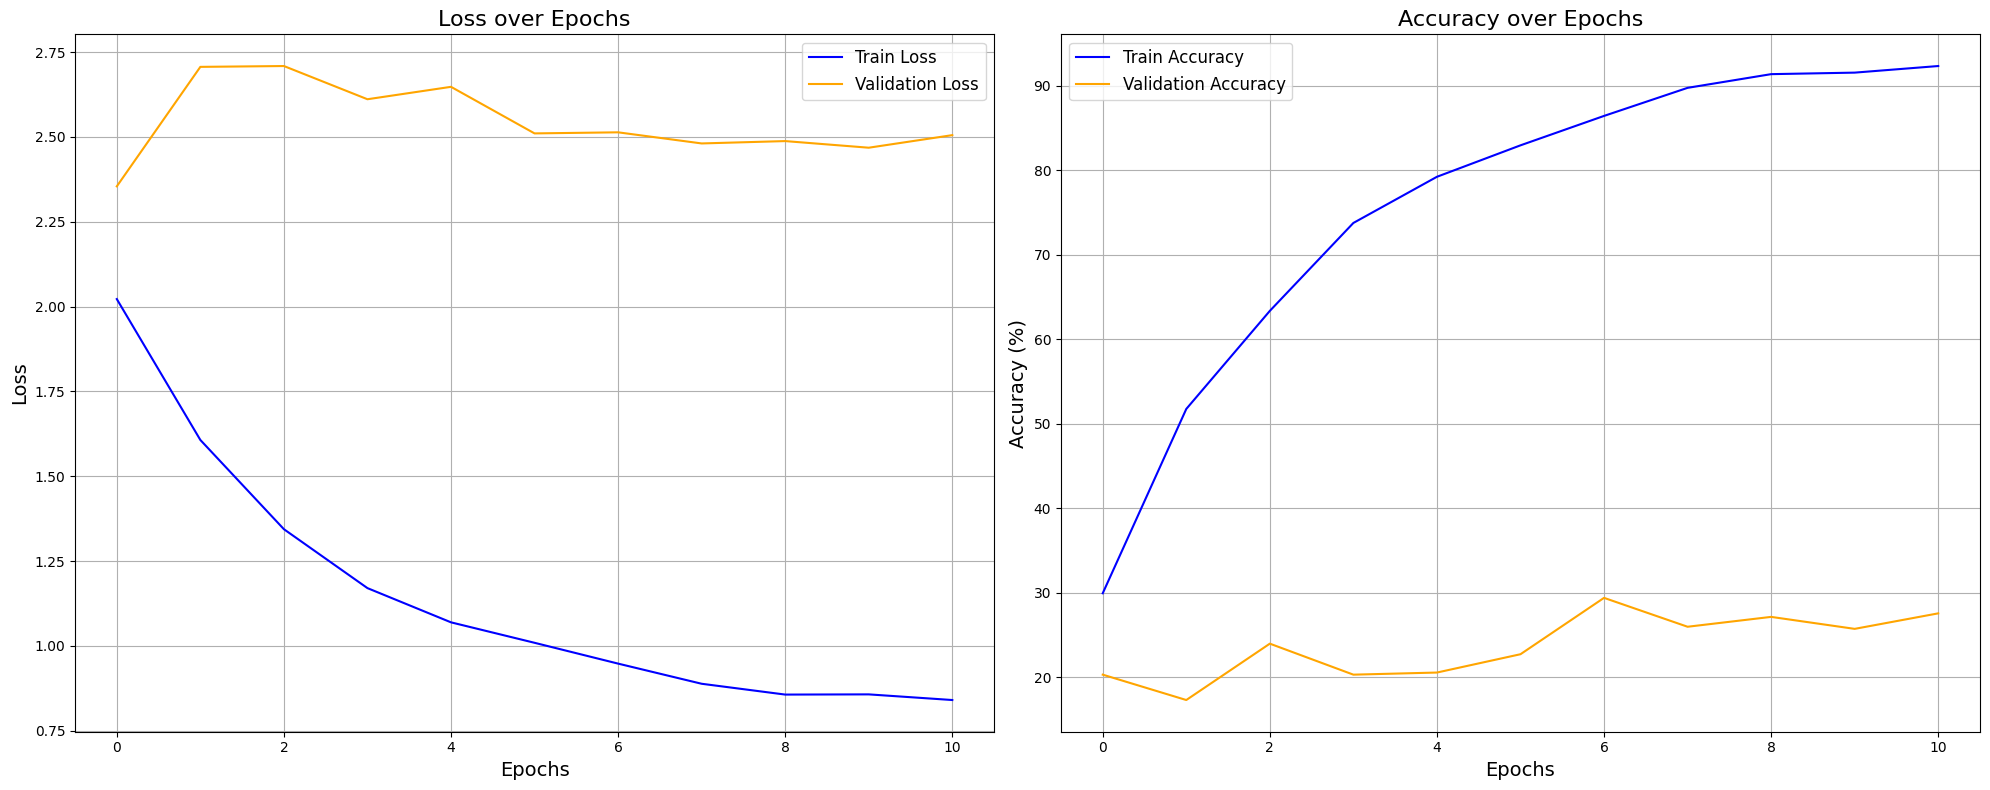

KeyboardInterrupt: 

In [9]:
from Models.OutputAggregation import OutputAggregation
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = OutputAggregation(device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train_(
    num_epochs=50,
    optimizer=optimizer,
    scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5),
    criterion=nn.CrossEntropyLoss(label_smoothing=0.1),
    train_loader=frameimage_train_loader_no_leakage,
    val_loader=frameimage_val_loader_no_leakage,
    plot=True
)

### 2.2.2. Late fusion with MLP

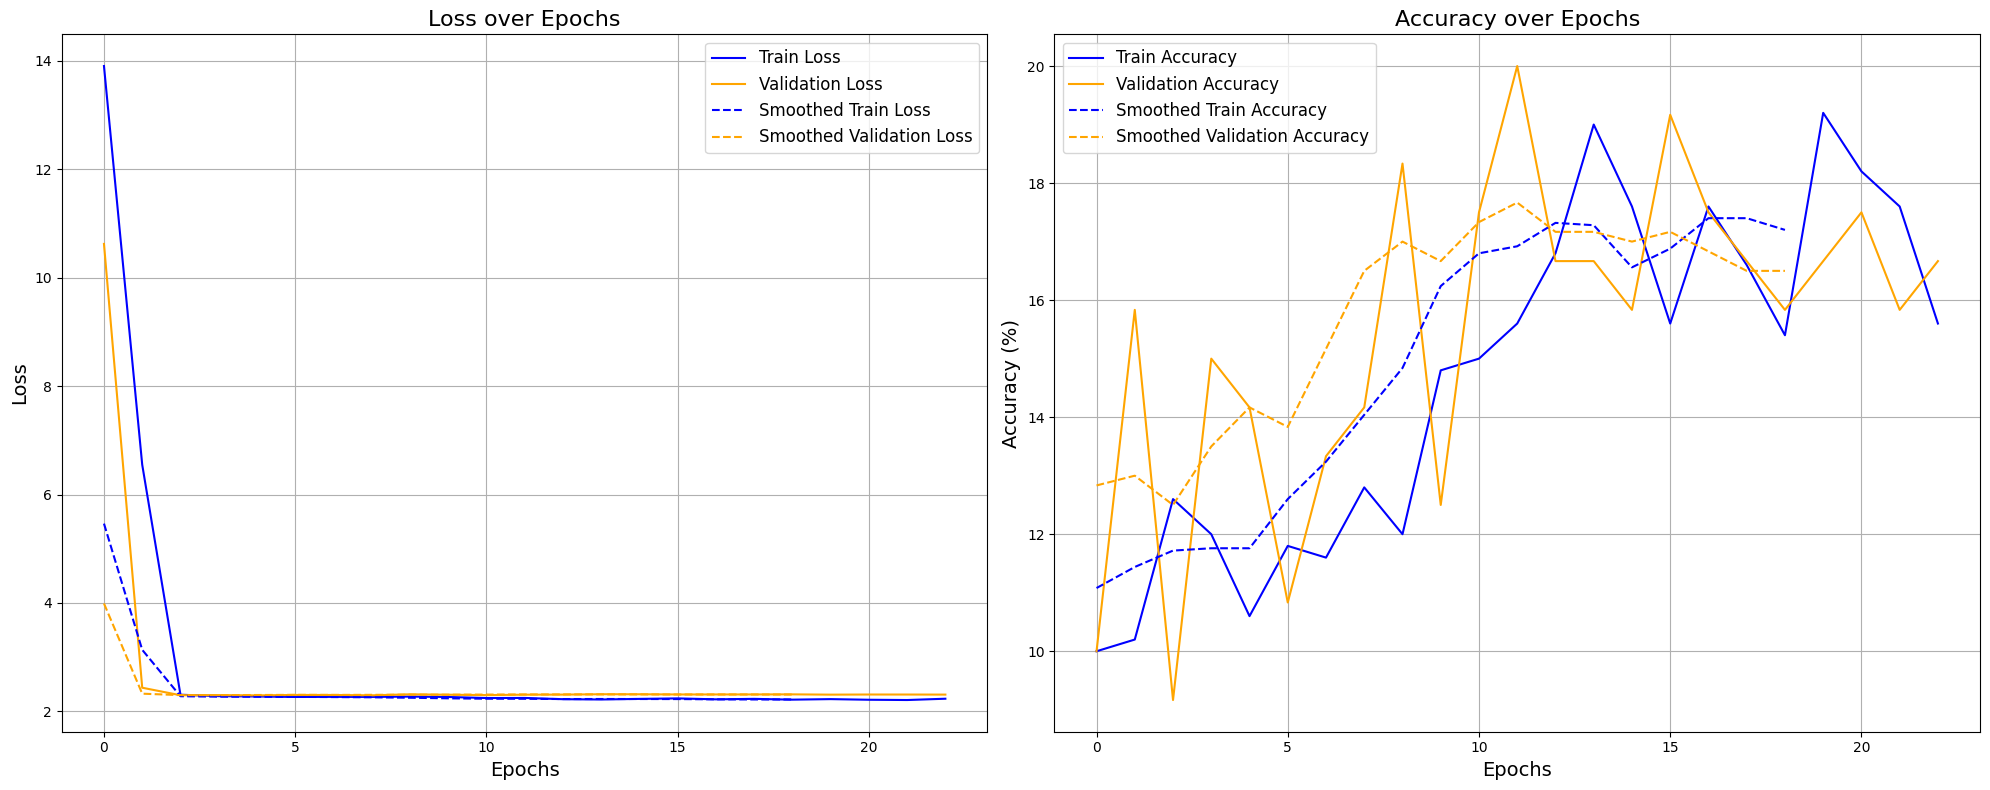

KeyboardInterrupt: 

In [10]:
from Models.LateFusionMLP import LateFusionMLP

model = LateFusionMLP(device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train_(
    num_epochs=50,
    optimizer=optimizer,
    scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5),
    criterion=nn.CrossEntropyLoss(label_smoothing=0.1),
    train_loader=framevideolist_train_loader_no_leakage,
    val_loader=framevideolist_val_loader_no_leakage,
    plot=True
)

### 2.2.3. Late fusion with Pooling

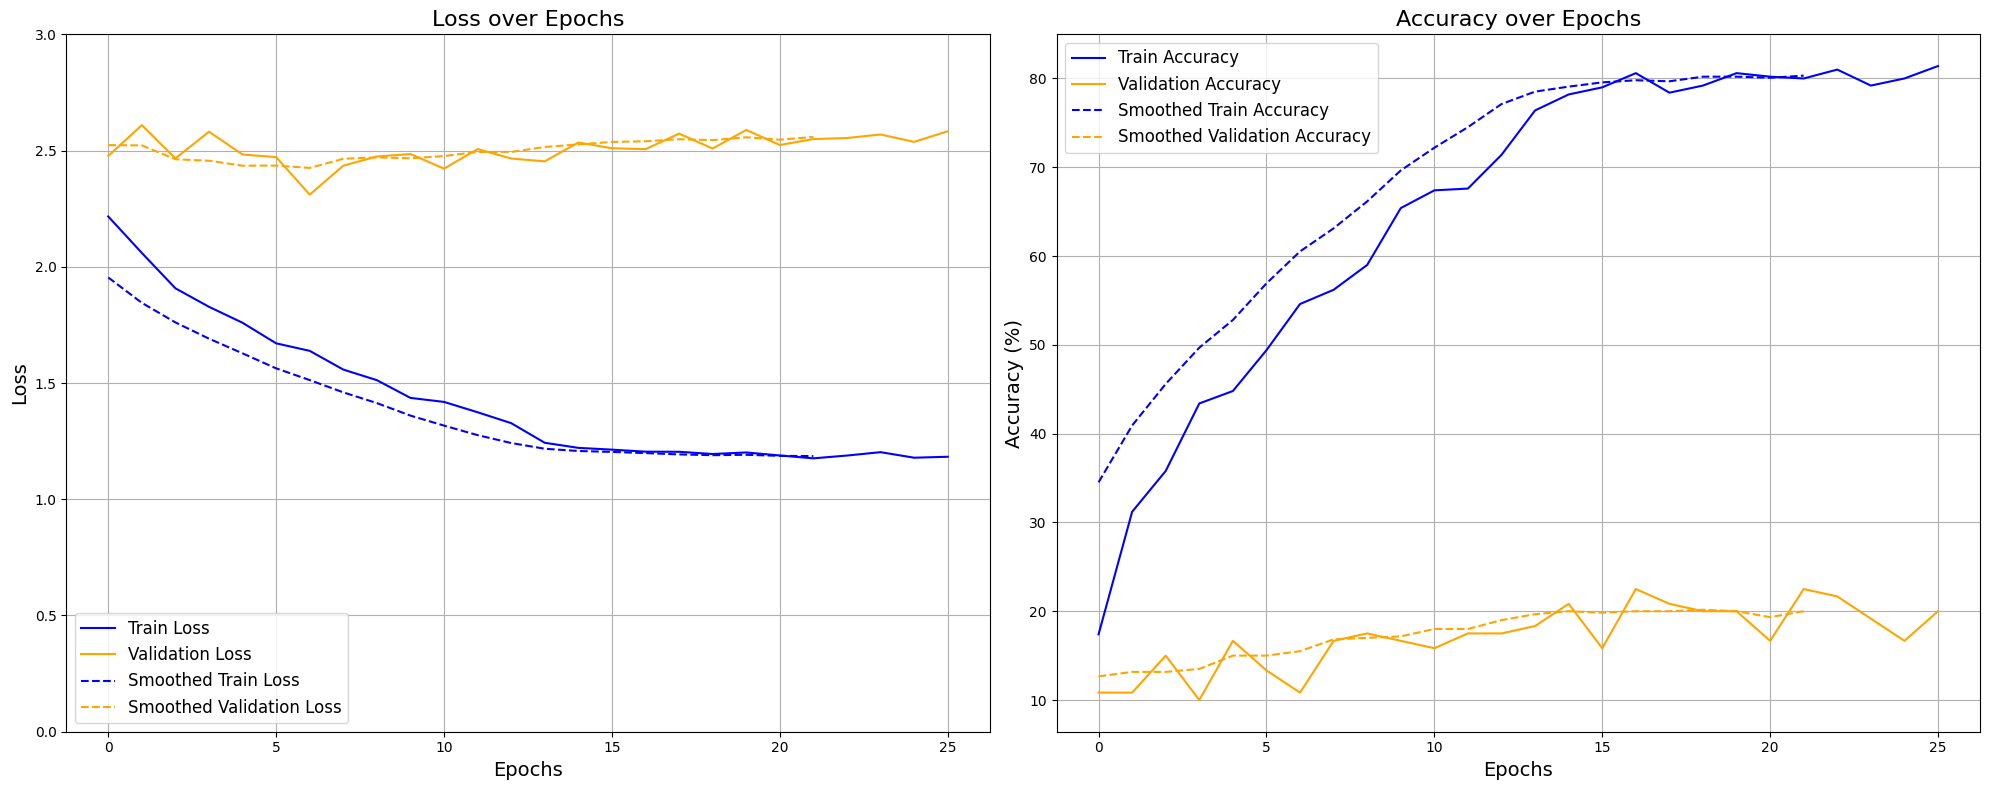

KeyboardInterrupt: 

In [7]:
from Models.LateFusionPooling import LateFusionPooling
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = LateFusionPooling(device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train_(
    num_epochs=50,
    optimizer=optimizer,
    scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5),
    criterion=nn.CrossEntropyLoss(label_smoothing=0.1),
    train_loader=framevideolist_train_loader_no_leakage,
    val_loader=framevideolist_val_loader_no_leakage,
    plot=True
)

### 2.2.4. Early fusion

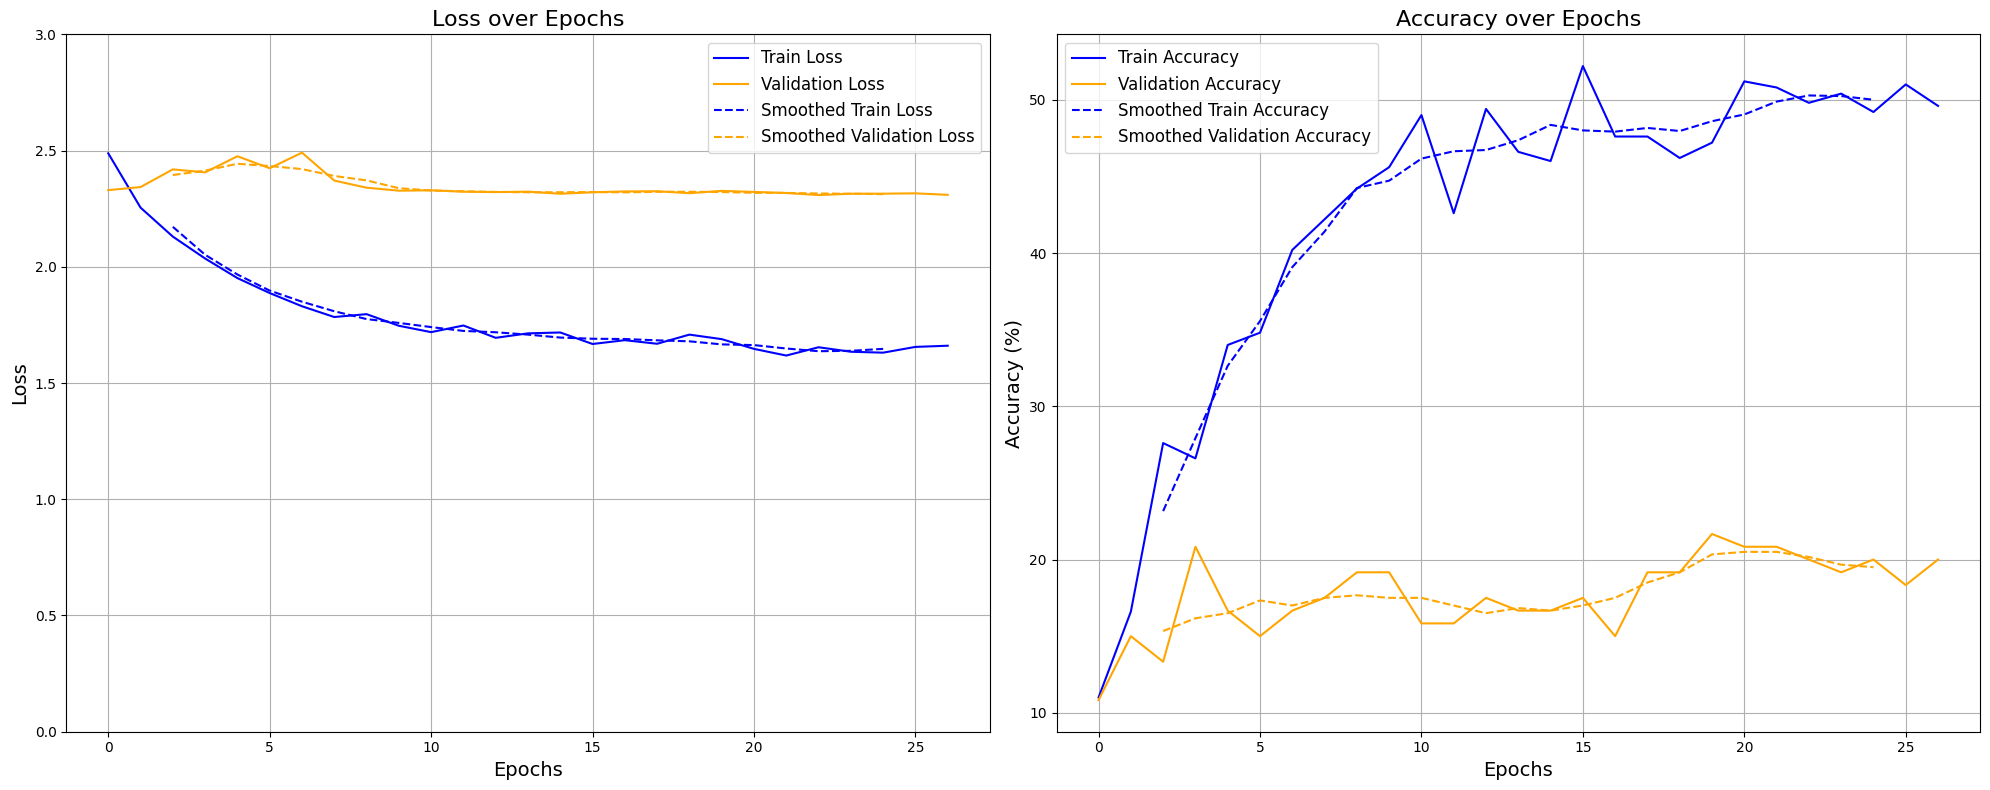

KeyboardInterrupt: 

In [9]:
from Models.EarlyFusion import EarlyFusion

model = EarlyFusion(device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train_(
    num_epochs=50,
    optimizer=optimizer,
    scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5),
    criterion=nn.CrossEntropyLoss(label_smoothing=0.1),
    train_loader=framevideolist_train_loader_no_leakage,
    val_loader=framevideolist_val_loader_no_leakage,
    plot=True
)

### 2.2.5. 3D CNN

In [7]:
from Models.CNN3D import CNN3D

model = CNN3D(device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train_(
    num_epochs=50,
    optimizer=optimizer,
    scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5),
    criterion=nn.CrossEntropyLoss(label_smoothing=0.1),
    train_loader=framevideolist_train_loader_no_leakage,
    val_loader=framevideolist_val_loader_no_leakage,
    plot=True
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.83 GiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 8.40 GiB is allocated by PyTorch, and 924.50 KiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

- - -
- - -
# 3. Dual Stream model

In [8]:
flow_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),                   
    T.Normalize(mean=[0.5] * 2, std=[0.5] * 2),
])

In [9]:
from DatasetLoader.FlowVideoDataset import FlowVideoDataset

flowvideo_train_loader = DataLoader(
    dataset=FlowVideoDataset(split='train', transform=flow_transform), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

flowvideo_val_loader = DataLoader(
    dataset=FlowVideoDataset(split='val', transform=flow_transform), 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

flowvideo_test_loader = DataLoader(
    dataset=FlowVideoDataset(split='test', transform=flow_transform), 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

In [10]:
from collections import Counter

train_labels = [label for _, label in frameimage_train_loader.dataset]
class_counts = Counter(train_labels)

NameError: name 'frameimage_train_loader' is not defined

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=classes, y=train_labels)
print(f"Class Counts: {class_counts}")

In [ ]:
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class Weights: {class_weights}")

In [11]:
from Models.DualStream import DualStream
model = DualStream(device).to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

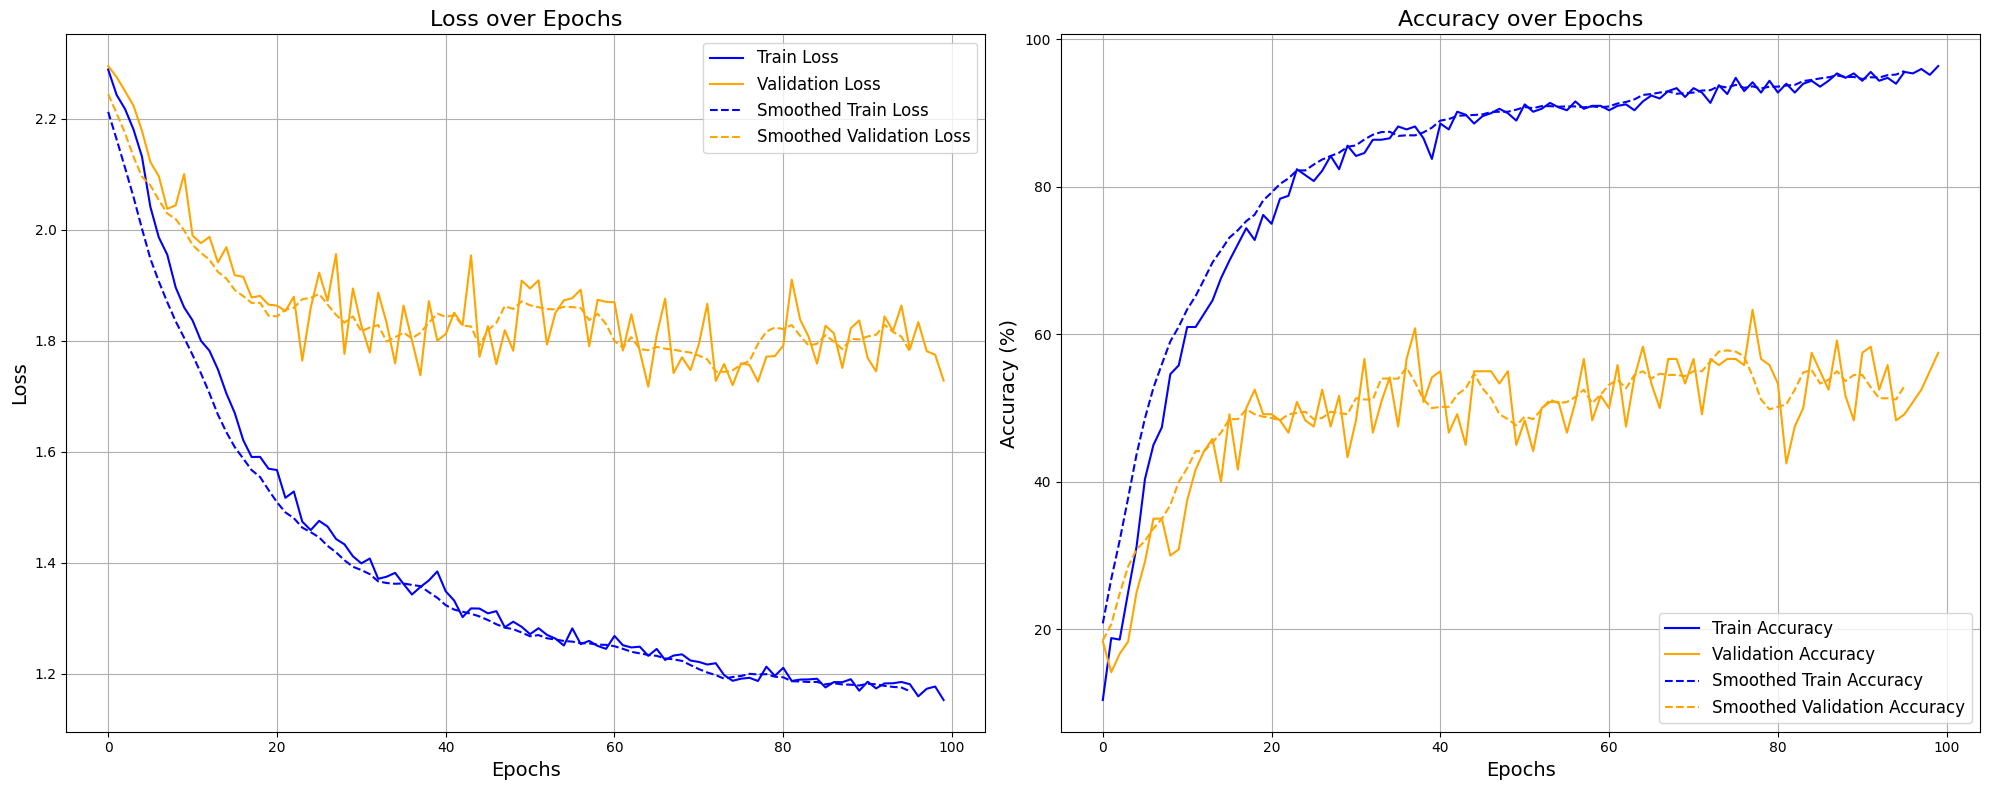

In [ ]:
model.train_(
    num_epochs=100,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=flowvideo_train_loader,
    val_loader=flowvideo_val_loader,
    plot=True
)